In [1]:
# Try to recreate least squares accuracy with regularizer

# Load split

import pickle

badIDs = [605515760919, 601983541597]

with open('../../Splits/RegressionAllTasks/split1.bin', 'rb') as f:
    d = pickle.load(f)
    train = []
    trainDirty = d['train']
    test = []
    testDirty = d['test']
    
    # Remove bad subjects
    for subj in trainDirty:
        if subj['ID'] not in badIDs:
            train.append(subj)
            
    for subj in testDirty:
        if subj['ID'] not in badIDs:
            test.append(subj)
    
print(len(train))
print(len(test))
print(train[0])

466
156
{'meta': {'AgeInMonths': 146, 'Gender': 'F', 'Ethnicity': 'AFRICAN', 'AgeGroupID': 2, 'AgeGroupEdge1': 144, 'AgeGroupEdge2': 180}, 'rest': '30', 'nback': '31', 'emoid': '31', 'ID': 600262185931}


In [2]:
# Load data

def loadTimeseries(_id, _dir):
    ts = None
    with open('{:s}/{:d}.bin'.format(_dir, _id), 'rb') as f:
        ts = pickle.load(f)
    return ts

train_rest_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in train]
# train_nback_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in train]
# train_emoid_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in train]

test_rest_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in test]
# test_nback_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in test]
# test_emoid_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in test]

print('Complete')

Complete


In [3]:
import numpy as np

def normalizeSubjects(subjects):
    for i in range(len(subjects)):
        subj = subjects[i]
        subj -= np.mean(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        subj /= np.std(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        if np.sum(np.isnan(subj)) > 0:
            print(i)
        if np.sum(np.isinf(subj)) > 0:
            print(i)

normalizeSubjects(train_rest_ts)
# normalizeSubjects(train_nback_ts)
# normalizeSubjects(train_emoid_ts)

normalizeSubjects(test_rest_ts)
# normalizeSubjects(test_nback_ts)
# normalizeSubjects(test_emoid_ts)

print('Complete')

Complete


In [4]:
# Calculare pearson matrices

train_rest_p = np.stack([np.corrcoef(sub) for sub in train_rest_ts])
test_rest_p = np.stack([np.corrcoef(sub) for sub in test_rest_ts])

# train_nback_p = np.stack([np.corrcoef(sub) for sub in train_nback_ts])
# test_nback_p = np.stack([np.corrcoef(sub) for sub in test_nback_ts])

print(train_rest_p[0].shape)
print('Complete')

(264, 264)
Complete


In [5]:
# Create feature vectors (right now just ages, maleness, and femaless)

X_train = []
for subj in train:
    maleness = 1 if subj['meta']['Gender'] == 'M' else 0
    femaleness = 1 if maleness == 0 else 0
    feat = np.array([subj['meta']['AgeInMonths'], maleness, femaleness])
    X_train.append(feat)
    
X_test = []
for subj in test:
    maleness = 1 if subj['meta']['Gender'] == 'M' else 0
    femaleness = 1 if maleness == 0 else 0
    feat = np.array([subj['meta']['AgeInMonths'], maleness, femaleness])
    X_test.append(feat)
    
X_train = np.vstack(X_train)
X_test = np.vstack(X_test)

print(X_train[10:20])
print('Complete')

[[193   1   0]
 [217   1   0]
 [233   1   0]
 [176   1   0]
 [116   0   1]
 [246   0   1]
 [164   1   0]
 [167   0   1]
 [202   0   1]
 [108   0   1]]
Complete


In [6]:
# Convert to torch

import torch

train_rest_p_torch = torch.from_numpy(train_rest_p).float()
# train_nback_p_torch = torch.from_numpy(train_nback_p).float()

test_rest_p_torch = torch.from_numpy(test_rest_p).float()
# test_nback_p_torch = torch.from_numpy(test_nback_p).float()

X_train_torch = torch.from_numpy(X_train).float()
X_test_torch = torch.from_numpy(X_test).float()

print(test_rest_p_torch.shape)
print('Complete')

torch.Size([156, 264, 264])
Complete


In [114]:
# Male only

def singleGender(ps, X, idx):
    psp = []
    Xp = []
    for i in range(X.shape[0]):
        if X[i,idx] == 1:
            psp.append(ps[i])
            Xp.append(X[i])
    return torch.stack(psp), torch.stack(Xp)

train_rest_p_torch, X_train_torch = singleGender(train_rest_p_torch, X_train_torch, 2)
test_rest_p_torch, X_test_torch = singleGender(test_rest_p_torch, X_test_torch, 2)

print(test_rest_p_torch.shape)
print('Complete')

torch.Size([83, 264, 264])
Complete


In [63]:
# Regular least squares

Atrain = train_rest_p_torch.reshape(train_rest_p_torch.shape[0],-1)
Btrain = X_train_torch[:,0]

w, qr = torch.lstsq(Btrain,Atrain)

print('Complete')

Complete


In [7]:
# 3rd order poly least squares

def make3rdOrder(ps):
    ps3 = []
    for i in range(ps.shape[0]):
        p = ps[i].flatten()
        pp = torch.cat([p, p**2, p**3, p**4, p**5])
        ps3.append(pp)
    return torch.stack(ps3)

# Atrain = make3rdOrder(train_rest_p_torch)
# Btrain = X_train_torch[:,0]

# print('Finished 3rd order')

# # w, qr = torch.lstsq(Btrain,Atrain)

print('Complete')

Complete


In [10]:
# MLP Least Squares

import torch
import torch.nn as nn
import torch.nn.functional as F

# nRoi = train_rest_p_torch.shape[1]

# class LstsqMLP(nn.Module):
#     def __init__(self):
#         super(LstsqMLP, self).__init__()
#         self.fc1 = nn.Linear(nRoi*nRoi,1)
        
#     def forward(self, x):
#         return self.fc1(x)
    
# mlp = LstsqMLP()
# optim = torch.optim.Adam(mlp.parameters(), lr=1e-3)

print('Complete')

Complete


In [11]:
# MLP Poly Least Squares

nRoi = train_rest_p_torch.shape[1]
order = 5

class PolyMLP(nn.Module):
    def __init__(self):
        super(PolyMLP, self).__init__()
        self.fc1 = nn.Linear(nRoi*nRoi*order+2,30)
        self.fc2 = nn.Linear(30,1)
        
    def forward(self, x):
        return self.fc2(F.relu(self.fc1(x)))

mlp = PolyMLP()
optim = torch.optim.Adam(mlp.parameters(), lr=1e-3)

print('Complete')

Complete


In [12]:
import random

N = train_rest_p_torch.shape[0]
running = 0
running_wd = 0
nEpoch = 1200
pPeriod = 100
nBatch = 20
wd = 20
# Atrain = train_rest_p_torch.reshape(N,-1)
Atrain = torch.cat([X_train_torch[:,1:3], make3rdOrder(train_rest_p_torch)], dim=1)
print('Finished making poly')

for epoch in range(nEpoch):
    batch = []
    truth = torch.zeros(nBatch)
    for i in range(nBatch):
        idx = random.randint(0,N-1)
        batch.append(Atrain[idx])
        truth[i] = X_train_torch[idx, 0]
    batch = torch.stack(batch)
    optim.zero_grad()
    pred = mlp(batch) 
    l0 = torch.sum((truth-pred.flatten())**2)
    l1 = 0
    for param in mlp.parameters():
        l1 += wd*torch.sum(param**2)
    running += l0.detach().cpu()
    running_wd = l1.detach().cpu()
    loss = l0 + l1
    loss.backward()
    optim.step()
    if epoch % pPeriod == 0 or epoch == nEpoch-1:
        if epoch != 0:
            if epoch % pPeriod != 0:
                running /= epoch % pPeriod
                running_wd /= epoch % pPeriod
            else:
                running /= pPeriod
                running_wd /= pPeriod
        print('epoch {:d} loss={:f} wdloss={:f}'.format(epoch, running, running_wd))
        running = 0
        running_wd = 0

print('Finished training')

Finished making poly
epoch 0 loss=654284.625000 wdloss=207.211395
epoch 100 loss=63683.093750 wdloss=44.996471
epoch 200 loss=17820.890625 wdloss=43.462624
epoch 300 loss=12679.541016 wdloss=47.060997
epoch 400 loss=9720.585938 wdloss=50.851540
epoch 500 loss=7994.115234 wdloss=52.536896
epoch 600 loss=6608.895020 wdloss=55.853115
epoch 700 loss=6593.445801 wdloss=55.992565
epoch 800 loss=6087.118652 wdloss=56.095287
epoch 900 loss=6727.821777 wdloss=54.144947
epoch 1000 loss=4700.870605 wdloss=53.721851
epoch 1100 loss=4411.528320 wdloss=51.924614
epoch 1199 loss=3589.322021 wdloss=51.318783
Finished training


[[1.         0.69930825]
 [0.69930825 1.        ]]
2.2304509845909126
1.7973700629340277


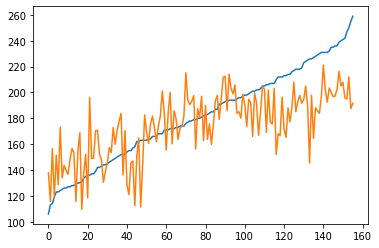

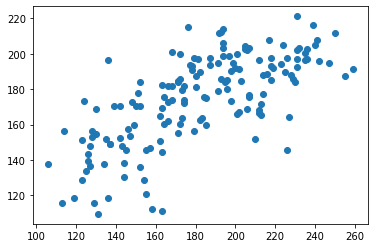

In [13]:
import matplotlib.pyplot as plt

# y = X_test_torch[:,0].detach().numpy()
# A = test_rest_p_torch.reshape(test_rest_p_torch.shape[0],-1)
# yPred = (A@w).flatten().detach().numpy()

# y = X_test_torch[:,0].detach().numpy()
# A = make3rdOrder(test_rest_p_torch)
# yPred = (A@w).flatten().detach().numpy()

# y = X_test_torch[:,0].detach().numpy()
# yPred = mlp(torch.cat([X_test_torch, 
#                        test_rest_p_torch.reshape(test_rest_p_torch.shape[0],-1)], dim=1))
# yPred = yPred.flatten().detach().numpy()

y = X_test_torch[:,0].detach().numpy()
yPred = mlp(torch.cat([X_test_torch[:,1:3], 
                       make3rdOrder(test_rest_p_torch)], dim=1))
yPred = yPred.flatten().detach().numpy()
    
idcs = np.argsort(y)
yPred = yPred[idcs]
y = y[idcs]

corr = np.corrcoef(y, yPred)
rmse = (np.sum((y-yPred)**2)/len(y))**0.5/12
mae = np.sum(np.abs(y-yPred))/12/len(y)

print(corr)
print(rmse)
print(mae)

plt.plot(y, label='Truth')
plt.plot(yPred, label='Prediction')
plt.show()

plt.scatter(y, yPred)
plt.show()

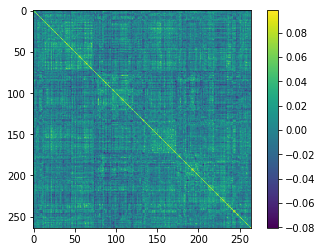

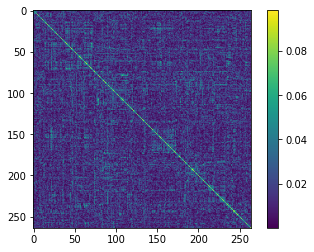

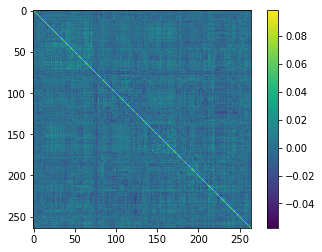

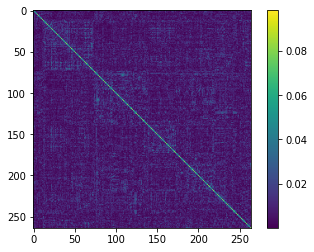

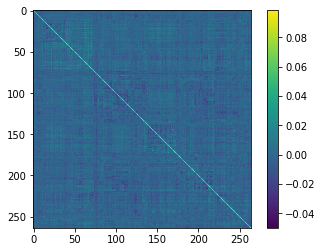

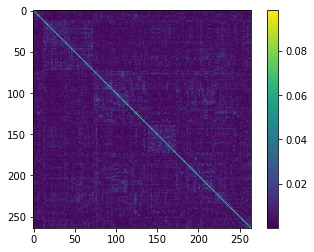

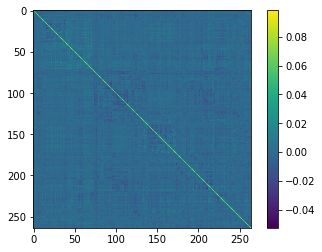

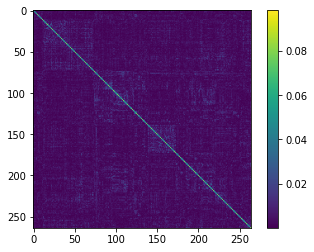

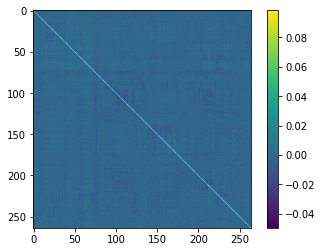

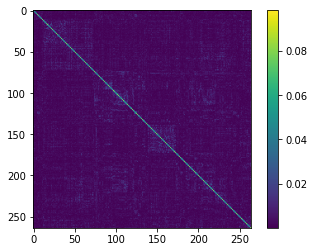

In [112]:
# Weights

nRoi = train_rest_p_torch.shape[1]
order = 5

for i in range(5):
    w1 = w[0,i*nRoi*nRoi:(i+1)*nRoi*nRoi].reshape(nRoi,nRoi).detach().numpy()

    plt.imshow(w1)
    plt.colorbar()
    plt.show()
    
    plt.imshow(np.abs(w1))
    plt.colorbar()
    plt.show()

In [110]:
print(5*nRoi*nRoi)
print(w.shape)

348480
torch.Size([1, 348480])


In [141]:
a = torch.tensor([[1,2,3],[3,4,5],[6,7,8]])
print(a)

b = torch.tensor([1,2,3]).unsqueeze(1)
print(a/b)

c = b.T
print(a/c)

tensor([[1, 2, 3],
        [3, 4, 5],
        [6, 7, 8]])
tensor([[1.0000, 2.0000, 3.0000],
        [1.5000, 2.0000, 2.5000],
        [2.0000, 2.3333, 2.6667]])
tensor([[1.0000, 1.0000, 1.0000],
        [3.0000, 2.0000, 1.6667],
        [6.0000, 3.5000, 2.6667]])


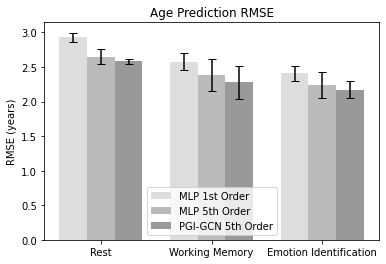

In [14]:
ind = np.arange(1,4)
width = 0.25

rmseMlp1 = (2.93, 2.573333333, 2.406666667)
rmseMlp5 = (2.65, 2.383333333, 2.236666667)
rmseMlp5Gcn = (2.58, 2.276666667, 2.173333333)

rmseMlp1Std = (0.065574385, 0.123423391, 0.106926766)
rmseMlp5Std = (0.104403065, 0.234591844, 0.191398363)
rmseMlp5GcnStd = (0.03, 0.237135685, 0.118462371)

plt.bar(ind, rmseMlp1, width, label='MLP 1st Order', 
        color='#ddd', yerr=rmseMlp1Std, capsize=4)
plt.bar(ind + width, rmseMlp5, width, label='MLP 5th Order', 
        color='#bbb', yerr=rmseMlp5Std, capsize=4)
plt.bar(ind + 2*width, rmseMlp5Gcn, width, label='PGI-GCN 5th Order', 
        color='#999', yerr=rmseMlp5GcnStd, capsize=4)

# plt.xlabel('fMRI Task')
plt.ylabel('RMSE (years)')
plt.title('Age Prediction RMSE')

plt.xticks(ind + width, ('Rest', 'Working Memory', 'Emotion Identification'))
plt.legend(loc='best')
plt.show()

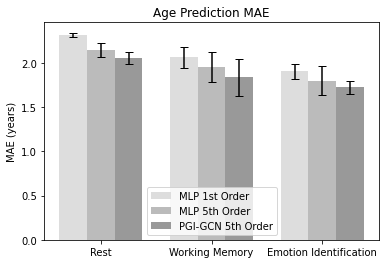

In [15]:
ind = np.arange(1,4)
width = 0.25

maeMlp1 = (2.316666667, 2.063333333, 1.903333333)
maeMlp5 = (2.143333333, 1.956666667, 1.8)
maeMlp5Gcn = (2.053333333, 1.84, 1.723333333)

maeMlp1Std = (0.025166115, 0.118462371, 0.085049005)
maeMlp5Std = (0.080829038, 0.171561456, 0.160934769)
maeMlp5GcnStd = (0.066583281, 0.21, 0.075718778)

plt.bar(ind, maeMlp1, width, label='MLP 1st Order', 
        color='#ddd', yerr=maeMlp1Std, capsize=4)
plt.bar(ind + width, maeMlp5, width, label='MLP 5th Order', 
        color='#bbb', yerr=maeMlp5Std, capsize=4)
plt.bar(ind + 2*width, maeMlp5Gcn, width, label='PGI-GCN 5th Order', 
        color='#999', yerr=maeMlp5GcnStd, capsize=4)

# plt.xlabel('fMRI Task')
plt.ylabel('MAE (years)')
plt.title('Age Prediction MAE')

plt.xticks(ind + width, ('Rest', 'Working Memory', 'Emotion Identification'))
plt.legend(loc='best')
plt.show()

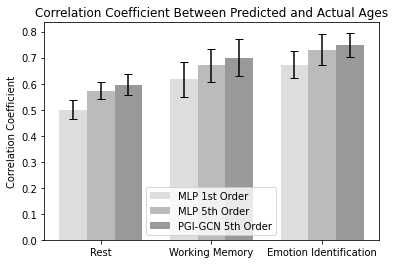

In [16]:
ind = np.arange(1,4)
width = 0.25

ccMlp1 = (0.5, 0.616666667, 0.673333333)
ccMlp5 = (0.573333333, 0.67, 0.73)
ccMlp5Gcn = (0.596666667, 0.7, 0.75)

ccMlp1Std = (0.036055513, 0.066583281, 0.051316014)
ccMlp5Std = (0.032145503, 0.06244998, 0.06)
ccMlp5GcnStd = (0.04163332, 0.072111026, 0.045825757)

plt.bar(ind, ccMlp1, width, label='MLP 1st Order', 
        color='#ddd', yerr=ccMlp1Std, capsize=4)
plt.bar(ind + width, ccMlp5, width, label='MLP 5th Order', 
        color='#bbb', yerr=ccMlp5Std, capsize=4)
plt.bar(ind + 2*width, ccMlp5Gcn, width, label='PGI-GCN 5th Order', 
        color='#999', yerr=ccMlp5GcnStd, capsize=4)

# plt.xlabel('fMRI Task')
plt.ylabel('Correlation Coefficient')
plt.title('Correlation Coefficient Between Predicted and Actual Ages')

plt.xticks(ind + width, ('Rest', 'Working Memory', 'Emotion Identification'))
plt.legend(loc='best')
plt.show()

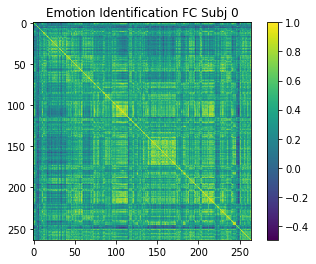

In [472]:
plt.imshow(train_rest_p[0])
plt.title('Emotion Identification FC Subj 0')
plt.colorbar()
plt.show()